### Database examples

for data management chapter

### Relational DB

Use SQLite to load the Eisenberg et al. data

#### Step 1: Load the demographics data from the URL

In [98]:
import sqlite3
import pandas as pd
import pymongo
import dotenv
import os
from neo4j import GraphDatabase
from chromadb import PersistentClient
import numpy as np
from tqdm.notebook import tqdm
from pathlib import Path
from database import setup_mongo_collection
from BetterCodeBetterScience.database_example_funcs import (
    get_melted_gwas_data,
    import_geneset_annotations_by_trait, 
    get_trait_info_from_ols,
    annotate_geneset_annotations_by_trait,
    get_gene_info
)
from BetterCodeBetterScience.database import get_mongo_client

dotenv.load_dotenv()
datadir = Path(os.getenv('DATA_DIR', '../../data'))

Idea: can the genetic relationships between diseases be inferred from the semantic distance of text related to the diseases?

### Step 1: load gwas-disease annotations 

- from https://www.ebi.ac.uk/gwas/docs/file-downloads

these might seem perfect for a relational database, but they are not quite ready, because one of the columns of interest (SNP_GENE_IDS, which maps the snp to one or more genes) maps to multiple genes. We could fix this by exploding the column:

In [3]:
gwas_data_melted = get_melted_gwas_data()

found data for 4329 unique PUBMEDIDs


This is now ready to import to a relational database. We could also simply import these to a document store, which we will do here.

In [3]:
import_geneset_annotations_by_trait(gwas_data_melted)

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 1878


100%|██████████| 3047/3047 [00:17<00:00, 174.38it/s]


Now let's do functional annotation of the gene sets for each GWAS result in the dataset.  

In [4]:
annotate_geneset_annotations_by_trait()

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 3047


  0%|          | 3/1169 [00:05<34:50,  1.79s/it]


KeyboardInterrupt: 

### Get trait info

In [7]:
get_trait_info_from_ols()

Pinged your deployment. You successfully connected to MongoDB!
Number of documents in trait_info_by_trait: 1617
Pinged your deployment. You successfully connected to MongoDB!
Number of documents in geneset_annotations_by_trait: 3047
Found 982 un-annotated trait URIs.


  1%|          | 8/982 [00:10<20:20,  1.25s/it]


KeyboardInterrupt: 

### Get pubmed abstracts for each trait using trait name and synomyms

### get abstracts from pubmed for each term + synonyms





In [ ]:

get_pmids_for_traits()


Pinged your deployment. You successfully connected to MongoDB!
Number of documents in trait_info_by_trait: 1625


Searching PubMed:   0%|          | 0/1625 [00:00<?, ?it/s]

PMIDs already exist for response to radiation, skipping...
PMIDs already exist for response to xenobiotic stimulus, skipping...
PMIDs already exist for response to lithium ion, skipping...
PMIDs already exist for response to gemcitabine, skipping...
PMIDs already exist for response to antidepressant, skipping...
PMIDs already exist for response to anticonvulsant, skipping...
PMIDs already exist for response to antibiotic, skipping...
PMIDs already exist for response to antineoplastic agent, skipping...
PMIDs already exist for response to carboplatin, skipping...
PMIDs already exist for response to bronchodilator, skipping...
PMIDs already exist for response to fenofibrate, skipping...
PMIDs already exist for response to ribavirin, skipping...
PMIDs already exist for response to cyclophosphamide, skipping...
PMIDs already exist for response to docetaxel trihydrate, skipping...
PMIDs already exist for response to doxorubicin, skipping...


In [32]:
traits = [i for i in geneset_collection.find() if 'functional_annotation' in i and len(i['functional_annotation']) > 0]
for trait in tqdm(traits):
    annotations = trait['functional_annotation']


  0%|          | 0/1878 [00:00<?, ?it/s]

In [34]:
trait['functional_annotation'][0]

{'source': 'GO:BP',
 'native': 'GO:2000539',
 'name': 'regulation of protein geranylgeranylation',
 'p_value': 0.04954183709047118,
 'significant': True,
 'description': '"Any process that modulates the frequency, rate or extent of protein geranylgeranylation." [GOC:obol]',
 'term_size': 1,
 'query_size': 1,
 'intersection_size': 1,
 'effective_domain_size': 21026,
 'precision': 1.0,
 'recall': 1.0,
 'query': 'query_1',
 'parents': ['GO:0010556', 'GO:0018344', 'GO:0031399']}

In [38]:
# get information about each gene 
geneset_collection = setup_mongo_collection('geneset_annotations_by_trait',  
    clear_existing=False)
pathway_collection = setup_mongo_collection('pathways',  
    clear_existing=False)

# loop through traits and add pathway information to the database
traits = [i for i in geneset_collection.find() 
    if 'functional_annotation' in i and len(i['functional_annotation']) > 0]

for trait in tqdm(traits):
    annotations = trait['functional_annotation']
    for pathway in annotations:
        # change key for clarity
        pathway['pathway_id'] = pathway.pop('native')

        pathway_collection.update_one(
            {'pathway_id': pathway['pathway_id']},
            {'$set': {'name': pathway.get('name', ''),
                      'source': pathway.get('source', ''),
                      'description': pathway.get('description', '')}},
            upsert=True
        )

Number of documents in geneset_annotations_by_trait: 3047
Number of documents in pathways: 0


  0%|          | 0/1878 [00:00<?, ?it/s]

In [2]:
# get information about each gene 
geneset_collection = setup_mongo_collection('geneset_annotations_by_trait',  
    clear_existing=False)
gene_collection = setup_mongo_collection('gene_info',  
    clear_existing=False)
geneset_docs = geneset_collection.find({})
unique_genes = set()
for doc in geneset_docs:
    genes = doc.get('gene_sets', [])
    unique_genes.update(genes)

print(f"Unique genes to annotate: {len(unique_genes)}")

# Now fetch gene info from Ensembl REST API


for gene in tqdm(unique_genes):
    # check if already in db
    existing = gene_collection.find_one({'gene_symbol': gene})
    if existing:
        continue
    res = get_gene_info(gene)
    # save to mongo gene_info collection
    gene_collection.update_one(
        {'gene_symbol': gene},
        {'$set': res},
        upsert=True
    )

Number of documents in geneset_annotations_by_trait: 3047
Number of documents in gene_info: 0
Unique genes to annotate: 16932


  0%|          | 0/16932 [00:00<?, ?it/s]

In [ ]:
fetch_and_store_pubmed_abstracts()

### add documents to chromadb vector db

In [ ]:
# add to chromadb vector db

pubmed_collection = setup_mongo_collection('pubmed_abstracts',  
    clear_existing=False)
pubmed_collection.create_index([('PMID', pymongo.ASCENDING)], unique=True)

client = PersistentClient(path="../../data/chroma_data")
# check if collection "pubmed_docs" exists, if not create it
if "pubmed_docs" in [col.name for col in client.list_collections()]:
    collection = client.get_collection(name="pubmed_docs")
    print("Using existing collection: pubmed_docs")
else:
    collection = client.create_collection(name="pubmed_docs")
    print("Created new collection: pubmed_docs")

# get ids (pmid) and documents (title + abstract) from pubmed_collection
ids = []
documents = []
for entry in pubmed_collection.find({}):
    full_text = entry.get('title', '') + ' ' + entry.get('abstract', '')
    documents.append(full_text)
    ids.append(str(entry['PMID']))

# exclude ids that are already in the chromadb collection
existing_ids = set(collection.get(ids=[]).ids)
ids_to_add = []
documents_to_add = []
for i, id_ in enumerate(ids):
    if id_ not in existing_ids:
        ids_to_add.append(id_)
        documents_to_add.append(documents[i])

# add in batches of 5000
batch_size = 5000
for i in range(0, len(ids_to_add), batch_size):
    batch_ids = ids_to_add[i:i + batch_size]
    batch_documents = documents_to_add[i:i + batch_size]
    collection.add(
        ids=batch_ids,
        documents=batch_documents
    )
    print(f"Added {len(batch_ids)} documents to chromadb collection")

### Graph database example

In [ ]:
# Assuming Neo4j is running locally with default credentials
# For production, use environment variables or secure config
# browse db at http://localhost:7474/browser/


#def load_trait_pathway_mappings():
if 1:
    # Connect to both databases
    geneset_annotations_by_trait = setup_mongo_collection(
        collection_name='geneset_annotations_by_trait')
    
    neo4j_driver = GraphDatabase.driver('bolt://localhost:7687', 
                                         auth=('neo4j', os.environ['NEO4J_PASSWORD']))

    with neo4j_driver.session() as session:
        # Clear existing data if needed
        session.run("MATCH (n) DETACH DELETE n")
        
        # Create constraints for performance
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (p:Phenotype) REQUIRE p.id IS UNIQUE")
        session.run("CREATE CONSTRAINT IF NOT EXISTS FOR (g:Gene) REQUIRE g.id IS UNIQUE")
        
        # add all pathways as nodes
        pathway_collection = setup_mongo_collection('pathways',  
            clear_existing=False)
        pathways = list(pathway_collection.find())
        for pathway in pathways:
            session.run("""
                MERGE (pw:Pathway {id: $pathway_id})
                SET pw.name = $name,
                    pw.source = $source,
                    pw.description = $description
            """, pathway_id=pathway['pathway_id'],
                 name=pathway.get('name', ''),
                 source=pathway.get('source', ''),
                 description=pathway.get('description', ''))
        
        # load all annotation data from MongoDB
        phenotypes = geneset_annotations_by_trait.find()
        
        for phenotype in phenotypes:
            phenotype_id = phenotype['mapped_trait_uri']
            pathways = [i['native'] for i in phenotype.get('functional_annotation', [])]
            if len(pathways) == 0:
                continue
            # Batch create nodes and relationships
            session.run("""
                MERGE (p:Phenotype {id: $phenotype_id})
                SET p.name = $name
                WITH p
                UNWIND $pathways AS pathway
                MERGE (g:Pathway {id: pathway})
                MERGE (p)-[:MAPPED_TO]->(g)
            """, phenotype_id=str(phenotype_id), 
                 name=phenotype.get('trait_name', ''),
                 pathways=pathways)

#load_phenotype_gene_mappings()

Number of documents in geneset_annotations_by_trait: 3047
Number of documents in pathways: 6073


In [42]:
# print total number of pathways and phenotypes in the database
with neo4j_driver.session() as session:
    result = session.run("MATCH (p:Phenotype) RETURN count(p) AS phenotype_count")
    phenotype_count = result.single()['phenotype_count']
    result = session.run("MATCH (pw:Pathway) RETURN count(pw) AS pathway_count")
    pathway_count = result.single()['pathway_count']
    print(f"Total Phenotypes in DB: {phenotype_count}")
    print(f"Total Pathways in DB: {pathway_count}")

Total Phenotypes in DB: 1878
Total Pathways in DB: 6073


In [74]:
from neo4j import GraphDatabase
import csv

neo4j_driver = GraphDatabase.driver('bolt://localhost:7687', 
                                        auth=('neo4j', os.environ['NEO4J_PASSWORD']))

with neo4j_driver.session() as session:
    try:
        session.run("CALL gds.graph.drop('phenotype-pathway-graph') YIELD graphName")
    except:
        pass  # graph did not exist

    session.run("""
        CALL gds.graph.project(
        'phenotype-pathway-graph',
        ['Phenotype', 'Pathway'],
        {
            MAPPED_TO: {
            orientation: 'UNDIRECTED'
            }
        }) """
    )

    results = session.run("""
        CALL gds.nodeSimilarity.stream('phenotype-pathway-graph')
        YIELD node1, node2, similarity
        WHERE gds.util.asNode(node1):Phenotype AND gds.util.asNode(node2):Phenotype
        RETURN gds.util.asNode(node1).id AS phenotype1,
            gds.util.asNode(node2).id AS phenotype2,
            similarity
        ORDER BY similarity DESC
    """)
    results = session.run("""
        CALL gds.nodeSimilarity.stream('phenotype-pathway-graph')
        YIELD node1, node2, similarity
        WITH node1, node2, similarity
        MATCH (p1:Phenotype), (p2:Phenotype)
        WHERE id(p1) = node1 AND id(p2) = node2
        RETURN p1.id AS phenotype1, p2.id AS phenotype2, similarity
        ORDER BY similarity DESC
    """)


    res = list(results)




Received notification from DBMS server: <GqlStatusObject gql_status='01N01', status_description='warn: feature deprecated with replacement. id is deprecated. It is replaced by elementId or consider using an application-generated id.', position=<SummaryInputPosition line=6, column=15, offset=203>, raw_classification='DEPRECATION', classification=<NotificationClassification.DEPRECATION: 'DEPRECATION'>, raw_severity='WARNING', severity=<NotificationSeverity.WARNING: 'WARNING'>, diagnostic_record={'_classification': 'DEPRECATION', '_severity': 'WARNING', '_position': {'offset': 203, 'line': 6, 'column': 15}, 'OPERATION': '', 'OPERATION_CODE': '0', 'CURRENT_SCHEMA': '/'}> for query: "\n        CALL gds.nodeSimilarity.stream('phenotype-pathway-graph')\n        YIELD node1, node2, similarity\n        WITH node1, node2, similarity\n        MATCH (p1:Phenotype), (p2:Phenotype)\n        WHERE id(p1) = node1 AND id(p2) = node2\n        RETURN p1.id AS phenotype1, p2.id AS phenotype2, similarity\n

Now use chromadb to get average text similarity for 

In [104]:
similarity_result_df = pd.DataFrame([{
    'phenotype1': record['phenotype1'],
    'phenotype2': record['phenotype2'],
    'similarity': record['similarity']
} for record in res])
similarity_result_df.shape

(12993, 3)

In [119]:
def vectorized_pairwise_similarity(set_a_ids, set_b_ids):
    """Vectorized computation of pairwise similarities"""
    client = PersistentClient(path="../../data/chroma_data")
    collection = client.get_collection(name="pubmed_docs")

    results_a = collection.get(ids=set_a_ids, include=['embeddings'])
    results_b = collection.get(ids=set_b_ids, include=['embeddings'])
    
    embeddings_a = np.array(results_a['embeddings'])
    embeddings_b = np.array(results_b['embeddings'])
    
    # Normalize embeddings
    embeddings_a = embeddings_a / np.linalg.norm(embeddings_a, axis=1, keepdims=True)
    embeddings_b = embeddings_b / np.linalg.norm(embeddings_b, axis=1, keepdims=True)
    
    # Compute similarity matrix
    similarity_matrix = embeddings_a @ embeddings_b.T
    
    return similarity_matrix.mean()


pmids_by_trait_collection = setup_mongo_collection('pmids_by_trait',  
    clear_existing=False)

text_similarities = []

results = []
for idx in similarity_result_df.index:
    pmids = []
    num_pmids = []

    for phenotype in [similarity_result_df.loc[idx, 'phenotype1'],
                      similarity_result_df.loc[idx, 'phenotype2']]:

        doc = pmids_by_trait_collection.find_one({'trait_uri': phenotype})
        if doc and 'pmids' in doc:
            pmids.append([str(i) for i in doc['pmids']])
            num_pmids.append(len(doc['pmids']))
        else:
            num_pmids.append(0)
    if len(pmids) == 2 and len(pmids[0]) > 0 and len(pmids[1]) > 0:
        tsim = vectorized_pairwise_similarity(pmids[0], pmids[1])
    else:
        tsim = None
    result = {
        'phenotype1': similarity_result_df.loc[idx, 'phenotype1'],
        'phenotype2': similarity_result_df.loc[idx, 'phenotype2'],
        'pathway_similarity': similarity_result_df.loc[idx, 'similarity'],
        'text_similarity': tsim,
        'num_pmids_phenotype1': num_pmids[0],
        'num_pmids_phenotype2': num_pmids[1],
    }
    results.append(result)



Number of documents in pmids_by_trait: 1625


np.float64(0.05763669696296382)

In [130]:
%load_ext rpy2.ipython

In [133]:
%%R -i results_df

if (!requireNamespace("lme4", quietly = TRUE)) {
    install.packages("lme4")
}
library(lme4)
model <- lmer(text_similarity ~ pathway_similarity + (1 | phenotype1) + (1 | phenotype2), data = results_df)
summary(model)  

Linear mixed model fit by REML ['lmerMod']
Formula: text_similarity ~ pathway_similarity + (1 | phenotype1) + (1 |  
    phenotype2)
   Data: results_df

REML criterion at convergence: -23792.4

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0519 -0.5377 -0.0797  0.3959  9.2419 

Random effects:
 Groups     Name        Variance Std.Dev.
 phenotype1 (Intercept) 0.001334 0.03653 
 phenotype2 (Intercept) 0.001086 0.03296 
 Residual               0.001994 0.04466 
Number of obs: 8040, groups:  phenotype1, 1221; phenotype2, 1106

Fixed effects:
                   Estimate Std. Error t value
(Intercept)        0.082235   0.001989   41.34
pathway_similarity 0.057691   0.003695   15.61

Correlation of Fixed Effects:
            (Intr)
pthwy_smlrt -0.588


Text(0.5, 1.0, 'Pathway Similarity vs Text Similarity')

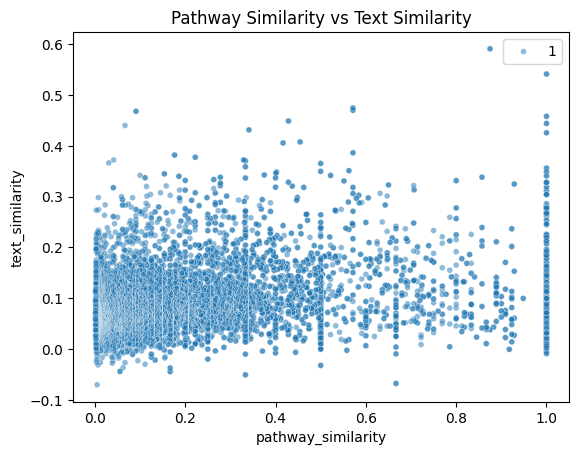

In [124]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(
    data=results_df,
    x='pathway_similarity',
    y='text_similarity',
    alpha=0.5,
    size=1
)
plt.title('Pathway Similarity vs Text Similarity')

In [127]:
# build a mixed effects model
import statsmodels.formula.api as smf
model = smf.mixedlm(
    "text_similarity ~ pathway_similarity",
    data=results_df,
    groups=results_df[["phenotype1", "phenotype2"]]
)
info = model.fit()
print(info.summary())

TypeError: unhashable type: 'numpy.ndarray'